In [1]:
import numpy as np
import vtk
import modules.utility as utility
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
import os
from scipy.interpolate import UnivariateSpline

Using TensorFlow backend.


In [2]:
mhas = open('images.txt').readlines()
mhas = [i.replace('\n','') for i in mhas]
# mhas = [i.split('/')[-1] for i in mhas]
# mhas = ['./data/'+i for i in mhas]

truths = open('truths.txt').readlines()
truths = [i.replace('\n','') for i in truths]

paths = open('paths.txt').readlines()
paths = [i.replace('\n','') for i in paths]

groups = open('groups.txt').readlines()
groups = [i.replace('\n','') for i in groups]

im_mr = open('mr_images.list').readlines()
im_mr = [i.replace('\n','') for i in im_mr]

im_ct = open('ct_images.list').readlines()
im_ct = [i.replace('\n','') for i in im_ct]

ct_val = open('ct_val.txt').readlines()
ct_val = [i.replace('\n','') for i in ct_val]

ct_test = open('ct_test.txt').readlines()
ct_test = [i.replace('\n','') for i in ct_test]

mr_val = open('mr_val.txt').readlines()
mr_val = [i.replace('\n','') for i in mr_val]

mr_test = open('mr_test.txt').readlines()
mr_test = [i.replace('\n','') for i in mr_test]

In [3]:
def normalize_grps(grp_dict,path_info):
    norm_grps = []
    for i in sorted(grp_dict.keys()):

            vecs = path_info[i-1]
            p = vecs[:3]
            t = vecs[3:6]
            tx= vecs[6:]
            c = grp_dict[i]['contour']

            contour_norm = utility.normalizeContour(c,p,t,tx)
            norm_grps.append(contour_norm)
    return norm_grps

def reinterp_grps(grps_list, num_pts=20):
    reinterp_list = [
        utility.interpContour(c,num_pts) for c in grps_list
    ]
    return reinterp_list

def loft_path(grps_list, grp_points, num_new_points, k=3):
    """
    Note grp_points and path_points should be sorted
    """
    xsplines = []
    ysplines = []
    
    gpts = np.asarray(grp_points)
    gpts = 1.0*gpts/np.amax(gpts)
    
    d = 1.0/num_new_points
    ppts = np.arange(0,1,d)
    
    num_contour_pts = len(grps_list[0])
    
    for i in range(num_contour_pts):
        x = [g[i,0] for g in grps_list]
        y = [g[i,1] for g in grps_list]
        
        x_s = UnivariateSpline(gpts,x,k=k)
        y_s = UnivariateSpline(gpts,y,k=k)
        
        xsplines.append(x_s)
        ysplines.append(y_s)
        
    new_grps = []
    for p in ppts:
        cpts = [[xsplines[i](p),ysplines[i](p)] 
                 for i in range(num_contour_pts)]
        new_grps.append(np.asarray(cpts))
        
    return new_grps

def get_all_lofted_segs(path, grp_fn, dims, spacing):
    
    total_groups = []
    total_segs = []
    processed_grps = []
    for grp_id in path.keys():
        grp = path[grp_id]['name']
        
        if os.path.exists(grp_fn+'/'+grp):
            
            path_info = path[grp_id]['points']

            grp_dict = utility.parseGroupFile(grp_fn+'/'+grp)

            norm_grps = normalize_grps(grp_dict,path_info)

            if len(norm_grps) > 3:
                print grp
                processed_grps.append(grp)
                
                interp_grps = reinterp_grps(norm_grps)

                lofted_grps = loft_path(interp_grps,sorted(grp_dict.keys()),len(path_info))

                total_groups += lofted_grps

                origin = [-spacing[0]*dims[0]/2,-spacing[1]*dims[1]/2]

                segs = [utility.contourToSeg(c,origin,dims,spacing) for c in
                       lofted_grps]

                total_segs += segs

    return total_segs,lofted_grps, processed_grps

In [4]:
grp_files = os.listdir(groups[0])
print grp_files
group_dict = utility.parseGroupFile(groups[0]+'/'+grp_files[0])
print group_dict.keys()
print group_dict[1]
print group_dict[1]['contour'].shape

['lt_vrtbrl_FINAL', 'rt_ext_crtd', 'rt_vrtbrl', 'lt_post_comm_FINAL', 'rt_ant_crbrl_FINAL', 'lt_crtd', 'rt_post_comm', 'rt_crtd_FINAL', 'lt_ant_crbrl_FINAL', 'group_contents.tcl', 'rt_post_comm_FINAL', 'arch_FINAL', 'lt_crtd_FINAL', 'lt_post_crbrl', 'rt_crtd', 'lt_ext_crtd', 'brchcph', 'rt_ext_crtd_FINAL', 'lt_sbclvn_FINAL', 'lt_post_crbrl_FINAL', 'brchcph_FINAL', 'rt_ant_crbrl', 'arch', 'rt_vrtbrl_FINAL', 'lt_post_comm', 'lt_sbclvn', 'lt_ext_crtd_FINAL', 'lt_vrtbrl', 'lt_ant_crbrl']
[1, 130, 5, 8, 138, 12, 17, 174, 150, 23, 29, 158, 35, 166, 41, 199, 178, 46, 50, 222, 182, 55, 185, 59, 189, 64, 195, 71, 202, 77, 208, 212, 86, 215, 228, 219, 94, 225, 100, 145, 110, 116, 121, 192]
{'points': [-0.52751000000000003, -0.93075999999999992, -18.125549899999996, 0.088606, -0.093584, 0.991661, 0.0, 0.995577, 0.093953], 'contour': array([[ -0.102   ,  -0.8811  , -18.1588  ],
       [ -0.1039  ,  -1.1349  , -18.1826  ],
       [ -0.2654  ,  -1.3264  , -18.1863  ],
       [ -0.5413  ,  -1.3272  ,

In [5]:
print paths[0]
path = utility.parsePathFile(paths[0])
print path.keys()
print path['200']['name']
print path['200']['points'][0]
print len(path['200']['points'])

/home/marsdenlab/datasets/vascular_data/OSMSC0001/0001_0001/0001_0001-cm.paths
['200', '900', '600', '450', '950', '350', '700', '550', '300', '400', '100', '500']
brchcph
[  2.32900000e-01   1.78400000e-01  -1.85725000e+01   1.07450000e-02
   6.50200000e-03   9.99921000e-01   0.00000000e+00   9.99979000e-01
  -6.50200000e-03]
200


In [6]:
# reader = vtk.vtkMetaImageReader()

# reader.SetFileName(mhas[0])
# reader.Update()
# the_image = reader.GetOutput()

# spacing = the_image.GetSpacing()
# dims = the_image.GetDimensions() 

# lofted_segs, lofted_grps = get_all_lofted_segs(path,groups[0],[192,192],spacing)

In [7]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# print lofted_grps[0].shape
# print lofted_segs[0].shape
# for i in range(len(lofted_grps)):
#     g = lofted_grps[i]
#     num_pts = len(g)
#     z = [i]*num_pts
#     ax.plot(g[:,0],g[:,1],z)
    
# plt.show()

# plt.figure()
# plt.imshow(lofted_segs[0])
# plt.colorbar()
# plt.show()

In [8]:
output_dir = "/media/marsdenlab/Data2/datasets/DeepLofting/"
ext = [191, 191]
DIMS = [192,192]
NUM_CONTOUR_PTS = 20

In [9]:
def ct_norm(x):
    return (1.0*x+1000)/(2000)

def mr_norm(x):
    x = np.log(1.0*x-np.amin(x)+1)
    m = np.amin(x)
    x = (x-m)/(np.amax(x)-m)    
    return x

def image_reader(fn_tup):
    
    img_fn, truth_fn, path_fn, grp_fn = fn_tup
    reader = vtk.vtkMetaImageReader()
    reader2 = vtk.vtkMetaImageReader()
    
    img_name = img_fn.split('/')[-2]

    reader.SetFileName(img_fn)
    reader.Update()
    the_image = reader.GetOutput()

    model = truth_fn
    model_name = model.split('/')[-2]

    print img_fn,truth_fn

    reader2.SetFileName(model)
    reader2.Update()
    the_model = reader2.GetOutput()
    
    path_dict = utility.parsePathFile(path_fn)
    
    return (the_image,the_model,path_dict,grp_fn)

def process_image(data_tup, f_x, f_y, f_c, normalizer):
    the_image, the_model, path_dict, grp_fn = data_tup

    spacing = the_image.GetSpacing()
    dims = the_image.GetDimensions()
    origin = [-ext[0]*spacing[0]/2,ext[1]*spacing[1]/2]
    minmax = the_image.GetScalarRange()    

    #tmpimages = utility.getAllImageSlices(the_image, path_dict, ext, True)
    #tmpsegs = utility.getAllImageSlices(the_model, path_dict, ext, True)
           
    tmpsegs, lofted_grps, grp_names = get_all_lofted_segs(path_dict,grp_fn,DIMS,spacing)

    tmpimages = []
    for p in path_dict.keys():
        grp = path_dict[p]['name']
        if os.path.exists(grp_fn+'/'+grp) and any([grp == g for g in grp_names]):
            print 'grp {} exists, getting images'.format(grp)
            for v in path_dict[p]['points']:
                i =utility.getImageReslice(the_image,ext,v[:3],v[3:6],v[6:9], True)
                tmpimages.append(i)
    
    tmpimages = np.asarray(tmpimages)[:,:,:,np.newaxis]
    tmpsegs = np.asarray(tmpsegs)[:,:,:,np.newaxis]
    lofted_grps = np.asarray(lofted_grps)
    print tmpimages.shape, tmpsegs.shape
#     tmpimages = np.transpose(tmpimages,axes=(0,2,3,1))
#     tmpsegs = np.transpose(tmpsegs,axes=(0,2,3,1))
    
    tmpimages = normalizer(tmpimages)
    tmpsegs = 1.0*tmpsegs/np.amax(tmpsegs)
    inds = [i for i in range(len(tmpimages)) if np.sum(tmpsegs[i])>0]
    print tmpimages.shape
    f_x.append(tmpimages[inds])
    f_y.append(tmpsegs[inds])
    f_c.append(lofted_grps)

In [10]:
def images_to_hdf5(image_list,
                   reader, post_processor, normalizer,shape, label_shape, dtype, label_dtype,
                   output_fn):
    """
    takes a list of images, post processes them and stores result in extendable
    hdf5 table
    
    inputs:
        - image_list, (list of strings), list of image filenames, readable by reader
        - reader, (function), reader compatible with the file type in image_list
        - post_processor, (function), post processes output of reader, must return list of np arrays with same shape
        - output_fn, (string), ouput filename, must be hdf5 file
    """
    EXPECTED_ROWS = 10000
    
    #create hdf5 file
    hdf5_file = tables.open_file(output_fn,'w')
    filters = tables.Filters(complevel=5, complib='blosc')
    
    data_storage = hdf5_file.create_earray(hdf5_file.root,'X',
                                      tables.Atom.from_dtype(dtype),
                                      shape=[0]+list(shape),
                                         filters=filters,
                                         expectedrows=EXPECTED_ROWS)
    
    label_storage = hdf5_file.create_earray(hdf5_file.root,'Y',
                                      tables.Atom.from_dtype(label_dtype),
                                      shape=[0]+list(label_shape),
                                         filters=filters,
                                         expectedrows=EXPECTED_ROWS)
    
    contour_shape = [NUM_CONTOUR_PTS,2]
    c_storage = hdf5_file.create_earray(hdf5_file.root,'C',
                                  tables.Atom.from_dtype(label_dtype),
                                  shape=[0]+contour_shape,
                                     filters=filters,
                                     expectedrows=EXPECTED_ROWS)
        
    for i in range(len(image_list)):
        print 'image {}'.format(i)
        data_tuple = reader(image_list[i])
        
        post_processor(data_tuple,data_storage,label_storage,c_storage,normalizer)
            
    hdf5_file.close()

In [11]:
train_ct = '/media/marsdenlab/Data2/datasets/DeepLofting/train_192_ct.hdf5'
val_ct = '/media/marsdenlab/Data2/datasets/DeepLofting/val_192_ct.hdf5'
test_ct = '/media/marsdenlab/Data2/datasets/DeepLofting/test_192_ct.hdf5'

train_mr = '/media/marsdenlab/Data2/datasets/DeepLofting/train_192_mr.hdf5'
val_mr = '/media/marsdenlab/Data2/datasets/DeepLofting/val_192_mr.hdf5'
test_mr = '/media/marsdenlab/Data2/datasets/DeepLofting/test_192_mr.hdf5'

In [12]:
ct_inds = [i for i in range(len(mhas)) if any([c in mhas[i] for c in im_ct])]
mr_inds = [i for i in range(len(mhas)) if any([c in mhas[i] for c in im_mr])]
ct_fn_tup = [(mhas[i],truths[i],paths[i],groups[i]) for i in ct_inds]
mr_fn_tup = [(mhas[i],truths[i],paths[i],groups[i]) for i in mr_inds]

print ct_fn_tup
print mr_fn_tup

[('/home/marsdenlab/datasets/vascular_data/OSMSC0001/OSMSC0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0001/0001_0001/0001_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0001/0001_0001/0001_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0001/0001_0001/0001_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0002/OSMSC0002-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0003/OSMSC0003-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0

In [13]:
ct_train_tups = []
ct_val_tups = []
ct_test_tups = []

for i in range(len(ct_fn_tup)):
    t = ct_fn_tup[i]
    fn = t[0]
    
    if any([c in fn for c in ct_val]):
        ct_val_tups.append(t)
    elif any([c in fn for c in ct_test]):
        ct_test_tups.append(t)
    else:
        ct_train_tups.append(t)
        
print "train"
print ct_train_tups

print "val"
print ct_val_tups

print "test"
print ct_test_tups

train
[('/home/marsdenlab/datasets/vascular_data/OSMSC0002/OSMSC0002-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0003/OSMSC0003-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0003/0003_0001/0003_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0005/OSMSC0005-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0005/0005_1001/0005_1001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0005/0005_1001/0005_1001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0005/0005_1001/0005_1001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/

In [ ]:
d = np.dtype(np.float16)
images_to_hdf5(ct_train_tups,
                   image_reader,
                   process_image, ct_norm, (ext[0]+1,ext[0]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   train_ct)

images_to_hdf5(ct_val_tups,
                   image_reader,
                   process_image, ct_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1),d, d,
                   val_ct)

images_to_hdf5(ct_test_tups,
                   image_reader,
                   process_image, ct_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   test_ct)

image 0
/home/marsdenlab/datasets/vascular_data/OSMSC0002/OSMSC0002-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0002/0002_0001/0002_0001-cm.mha
LCX_b1


/home/marsdenlab/anaconda2/lib/python2.7/site-packages/scipy/interpolate/fitpack2.py:224: UserWarning:


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.



RCA_b4
LAD_b3_b1
RCA_b1_b1
RCA_b1
RCA_b2
RCA_b3
RCA_b3_b1
LCX_b4_b1
aorta
LCX
LAD
LAD_b1
RCA
LAD_b3
LAD_b2
LAD_b5
LAD_b4
aorta
RCA_b3
RCA_b4
aorta
LAD_b2
LAD_b6
LCX_b2
LCX_b1
LCX_b4
LCX_b3
LCX_b6
LCX_b5
grp LCX_b1 exists, getting images
grp RCA_b4 exists, getting images
grp LAD_b3_b1 exists, getting images
grp RCA_b1_b1 exists, getting images
grp RCA_b1 exists, getting images
grp RCA_b2 exists, getting images
grp RCA_b3 exists, getting images
grp RCA_b3_b1 exists, getting images
grp LCX_b4_b1 exists, getting images
grp aorta exists, getting images
grp LCX exists, getting images
grp LAD exists, getting images
grp LAD_b1 exists, getting images
grp RCA exists, getting images
grp LAD_b3 exists, getting images
grp LAD_b2 exists, getting images
grp LAD_b5 exists, getting images
grp LAD_b4 exists, getting images
grp aorta exists, getting images
grp RCA_b3 exists, getting images
grp RCA_b4 exists, getting images
grp aorta exists, getting images
grp LAD_b2 exists, getting images
grp LAD_b6 exis

In [10]:
mr_train_tups = []
mr_val_tups = []
mr_test_tups = []

for i in range(len(mr_fn_tup)):
    t = mr_fn_tup[i]
    fn = t[0]
    
    if any([c in fn for c in mr_val]):
        mr_val_tups.append(t)
    elif any([c in fn for c in mr_test]):
        mr_test_tups.append(t)
    else:
        mr_train_tups.append(t)
        
print "train"
print mr_train_tups

print "val"
print mr_val_tups

print "test"
print mr_test_tups

train
[('/home/marsdenlab/datasets/vascular_data/OSMSC0066/OSMSC0066-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0066/0066_0001/0066_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0066/0066_0001/0066_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0068/OSMSC0068-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0068/0068_0001/0068_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0068/0068_0001/0068_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0069/OSMSC0069-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0069/0069_0001/0069_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0069/0069_0001/0069_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0071/OSMSC0071-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0071/0071_0001/0071_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0071/0071_0001/0071_0001-cm.paths'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0072/OSMSC

In [11]:
d = np.dtype(np.float16)
images_to_hdf5(mr_train_tups,
                   image_reader,
                   process_image, mr_norm, (ext[0]+1,ext[0]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   train_mr)

images_to_hdf5(mr_val_tups,
                   image_reader,
                   process_image, mr_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1),d, d,
                   val_mr)

images_to_hdf5(mr_test_tups,
                   image_reader,
                   process_image, mr_norm, (ext[0]+1,ext[1]+1,1), (ext[0]+1,ext[1]+1,1), d, d,
                   test_mr)

image 0
/home/marsdenlab/datasets/vascular_data/OSMSC0066/OSMSC0066-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0066/0066_0001/0066_0001-cm.mha
(700, 192, 192, 1) (700, 192, 192, 1)
(700, 192, 192, 1)
image 1
/home/marsdenlab/datasets/vascular_data/OSMSC0068/OSMSC0068-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0068/0068_0001/0068_0001-cm.mha
(700, 192, 192, 1) (700, 192, 192, 1)
(700, 192, 192, 1)
image 2
/home/marsdenlab/datasets/vascular_data/OSMSC0069/OSMSC0069-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0069/0069_0001/0069_0001-cm.mha
(750, 192, 192, 1) (750, 192, 192, 1)
(750, 192, 192, 1)
image 3
/home/marsdenlab/datasets/vascular_data/OSMSC0071/OSMSC0071-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0071/0071_0001/0071_0001-cm.mha
(700, 192, 192, 1) (700, 192, 192, 1)
(700, 192, 192, 1)
image 4
/home/marsdenlab/datasets/vascular_data/OSMSC0072/OSMSC0072-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0072/0072_0001/0072_0001-cm.mha
(700, 192, 1

(2950, 192, 192, 1)
image 0
/home/marsdenlab/datasets/vascular_data/OSMSC0079/OSMSC0079-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0079/0079_0001/0079_0001-cm.mha
(6398, 192, 192, 1) (6398, 192, 192, 1)
(6398, 192, 192, 1)
image 1
/home/marsdenlab/datasets/vascular_data/OSMSC0090/OSMSC0090-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0090/0090_0001/0090_0001-cm.mha
(1400, 192, 192, 1) (1400, 192, 192, 1)
(1400, 192, 192, 1)
image 2
/home/marsdenlab/datasets/vascular_data/OSMSC0134/OSMSC0134-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0134/0134_0002/0134_0002-cm.mha
(10500, 192, 192, 1) (10500, 192, 192, 1)
(10500, 192, 192, 1)
image 0
/home/marsdenlab/datasets/vascular_data/OSMSC0006/OSMSC0006-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0006/0006_0001/0006_0001-cm.mha
(875, 192, 192, 1) (875, 192, 192, 1)
(875, 192, 192, 1)
image 1
/home/marsdenlab/datasets/vascular_data/OSMSC0078/OSMSC0078-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0078/0078_00

In [12]:
f = tables.open_file(train_ct, 'r')

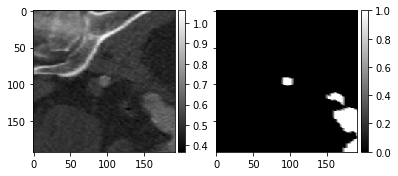

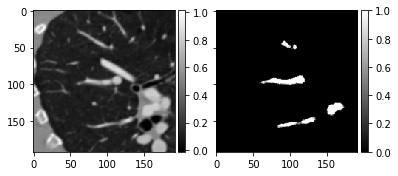

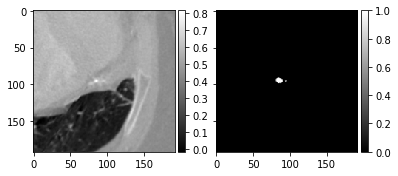

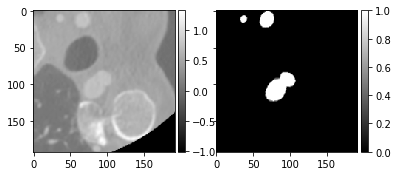

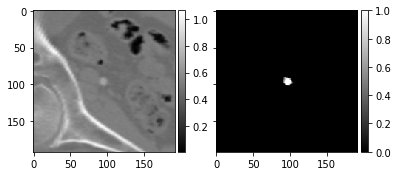

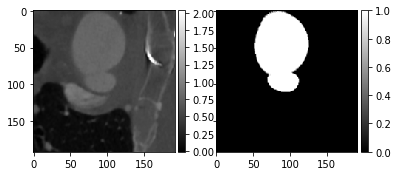

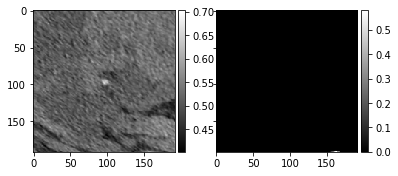

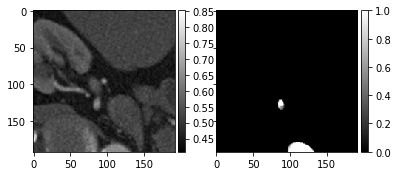

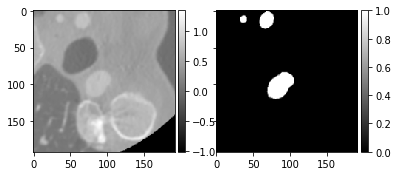

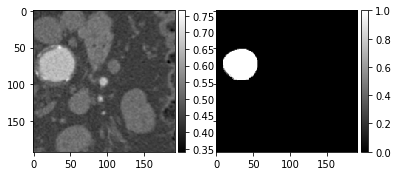

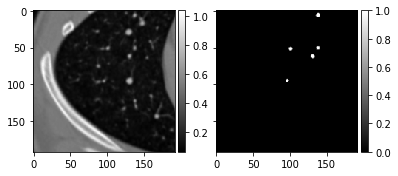

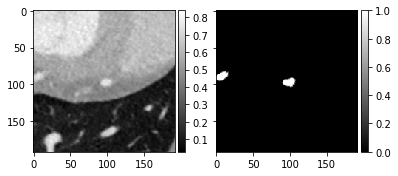

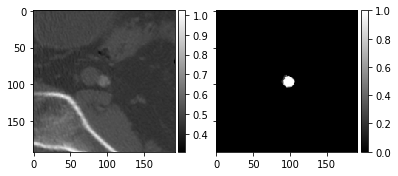

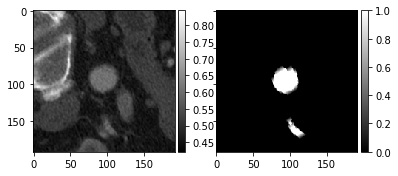

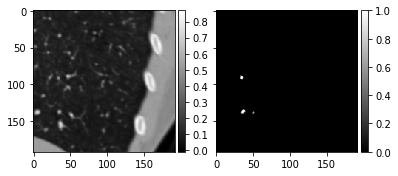

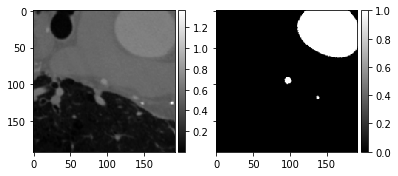

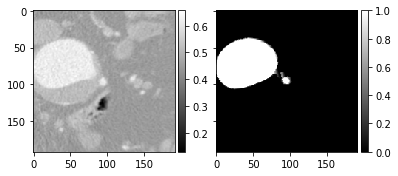

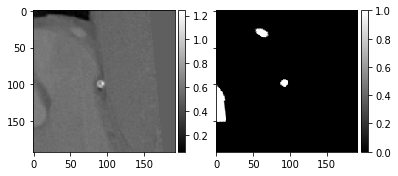

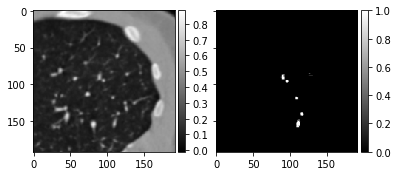

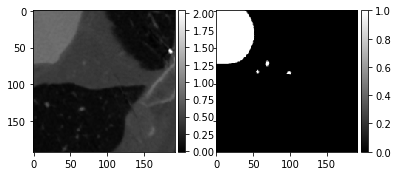

In [13]:
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    
for i in range(20):
    j = np.random.randint(len(f.root.X))

    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    implot(f.root.X[j,:,:,0],ax1)
    implot(f.root.Y[j,:,:,0],ax2)

    plt.tight_layout
    plt.show()
    
plt.close('all')

In [ ]:
path_dict = utility.parsePathFile(paths[0])

In [ ]:
print path_dict

In [ ]:
print path_dict['200']
print type(path_dict['200']['points'])

In [23]:
img_fn = mhas[0]
truth_fn = truths[0]
path_fn = paths[0]
reader = vtk.vtkMetaImageReader()
reader2 = vtk.vtkMetaImageReader()

img_name = img_fn.split('/')[-2]

reader.SetFileName(img_fn)
reader.Update()
the_image = reader.GetOutput()

model = truth_fn
model_name = model.split('/')[-2]

print img_fn,truth_fn

reader2.SetFileName(model)
reader2.Update()
the_model = reader2.GetOutput()

path_dict = utility.parsePathFile(path_fn)

/home/marsdenlab/datasets/vascular_data/OSMSC0001/OSMSC0001-cm.mha /home/marsdenlab/datasets/vascular_data/OSMSC0001/0001_0001/0001_0001-cm.mha


In [25]:
normalizer = ct_norm
spacing = the_image.GetSpacing()
dims = the_image.GetDimensions()
origin = [-ext[0]*spacing[0]/2,ext[1]*spacing[1]/2]
minmax = the_image.GetScalarRange()    

tmpimages = utility.getAllImageSlices(the_image, path_dict, ext, True)
tmpsegs = utility.getAllImageSlices(the_model, path_dict, ext, True)

tmpimages = np.asarray(tmpimages)
tmpsegs = np.asarray(tmpsegs)

tmpimages = np.transpose(tmpimages,axes=(0,2,3,1))
tmpsegs = np.transpose(tmpsegs,axes=(0,2,3,1))

tmpimages = normalizer(tmpimages)
tmpsegs = 1.0*tmpsegs/np.amax(tmpsegs)
inds = [i for i in range(len(tmpimages)) if np.sum(tmpsegs[i])>0]

In [28]:
print len(tmpimages)
print len(tmpsegs)
print len(inds)
print tmpsegs[0].shape

2700
2700
300
(192, 192, 1)
